#0.Introduction

This notebook is the documentation for Hology v7 Data Mining Competition by **Tim Apalah**

Member:
* Adzka Bagus Juniarta
* Ramadhani Februarrahman

This documentation covers explanations for our submission of 0.97 Exact Match Ratio on Public Leaderboard.

The trained model (.pth) can be downloaded [here](https://drive.google.com/drive/folders/13g40Yt2qv4phHfimCIFVIrHYwq6aZSlW?usp=sharing)

#1.Packages, Random Seed, and Directories setup

This section ensures that all the tools and libraries needed for model development are ready. We maintain reproducibility through random seeds, which ensures that model training results are consistent. The use of torch.backends.cudnn configurations ensures deterministic behavior on GPUs. Additionally, Google Drive is mounted to access any necessary datasets stored there (as our Team doing the model development in Google Colab).

**To be able to run this notebook without error, please setup your folder in the following structure:**

In your root Google Drive, create folder 'hologyv7' and paste this notebook there. Inside 'hologyv7' folder, create folder 'clothing_dataset' and paste the 'train/train/' training images folder there along with the 'test/test/' test images folder. Additionally, inside 'clothing_dataset', please paste the 'labels.csv' (training images labels) and the trained 'EfficientNetB7_MTL_Tim_Apalah.pth' model.

Finally, turn on the GPU runtime of Colab for ease of computation.

In [ ]:
# Section 1: Packages, Random Seed, and Directories Setup

import os  # For file and directory operations
import pandas as pd  # For handling tabular data (.csv)
import numpy as np  # For numerical operations and random number handling
import cv2  # OpenCV library for image processing
import matplotlib.pyplot as plt  # For plotting graphs and images
from sklearn.model_selection import train_test_split  # For dataset splitting
import torch  # PyTorch: deep learning library
from torch import nn, optim  # Neural network modules and optimization algorithms
from torch.utils.data import Dataset, DataLoader  # For creating datasets and data loaders
from torchvision import transforms, models  # Data transformations and pre-trained models
from torch.optim.lr_scheduler import ReduceLROnPlateau  # Learning rate scheduler
from tqdm.notebook import tqdm  # Progress bar for monitoring loops
import random  # For setting random seeds



def set_seed(seed=42):
    """
    Sets the seed for Python, NumPy, and PyTorch to ensure reproducible results.
    Also disables certain optimizations in PyTorch to make results deterministic.
    """
    random.seed(seed)  # Seed Python's built-in random library
    np.random.seed(seed)  # Seed NumPy's random generator
    torch.manual_seed(seed)  # Seed PyTorch (for CPU)

    if torch.cuda.is_available():  # If GPU is available, set seeds for CUDA
        torch.cuda.manual_seed(seed)  # Seed GPU operations

        # Ensure deterministic results by disabling certain optimizations
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False

# Set the seed to ensure consistency
set_seed(42)



# Mount Google Drive (if using Colab) to access datasets and trained model
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


#2.Load and Inspect Training Images' Labels

We rename the train.csv (labels for training images) to labels.csv to make it more understandable for us. In this section we do a little exploration on the train images classes distribution.

In [ ]:
# Section 2: Load and Inspect Training Images' Labels

labels_df = pd.read_csv('/content/drive/MyDrive/hologyv7/clothing_dataset/labels.csv')
labels_df.head()

,id,jenis,warna
0,1,1,1
1,2,0,2
2,3,1,3
3,4,1,1
4,5,0,4


In label 'jenis', class 0:Kaos is more dominant with proportion of around 61% (476 images) of total 777 train images.

In [ ]:
labels_df.value_counts('jenis')

,count
jenis,
0,476
1,301


In label 'warna', class 3:Hitam is more dominant with proportion of around 30.1% (234 images) of total 777 train images, followed with 2:Biru (20.8%), 4:Putih (18%), 1:Kuning (16%), and lastly 0:Merah (14.9%)

In [ ]:
labels_df.value_counts('warna')

,count
warna,
3,234
2,162
4,140
1,125
0,116


This observation provides information that there is no significant imbalance in the class distribution

#3.Define a Custom Dataset Class

This section defines a custom dataset class called ClothingDataset that inherits from torch.utils.data.Dataset. This class allows loading, processing, and transformation of images alongside their associated labels.

In [ ]:
# Section 3: Define a Custom Dataset Class

class ClothingDataset(Dataset):
    def __init__(self, df, img_dir, transform=None, is_test=False):
        """
        Initializes the dataset with the label DataFrame, image directory, and optional transformations.

        Args:
            df (pd.DataFrame): DataFrame containing image IDs and their labels.
            img_dir (str): Directory where the images are stored.
            transform (callable, optional): Transformation function to apply to the images.
            is_test (bool): If True, labels are not returned (used for inference).
            return_original (bool): If True, also returns the original untransformed image.
        """
        self.df = df
        self.img_dir = img_dir
        self.transform = transform
        self.is_test = is_test

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        img_id = str(self.df.iloc[idx, 0])
        img_name_jpg = os.path.join(self.img_dir, f"{img_id}.jpg")
        img_name_png = os.path.join(self.img_dir, f"{img_id}.png")

        # Load the image
        image = cv2.imread(img_name_jpg) if os.path.exists(img_name_jpg) else cv2.imread(img_name_png)
        if image is None:
            raise FileNotFoundError(f"Image {img_id} not found as .jpg or .png.")
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        # Apply transformations
        if self.transform:
            image = self.transform(image)

        if self.is_test:
            # For test set, return only the image
            return image
        else:
            # For training/validation, also return labels
            jenis = self.df.iloc[idx, 1]  # Jenis label
            warna = self.df.iloc[idx, 2]  # Warna label
            return image, jenis, warna

#4.Define Image Transformations (Data Augmentations)

To build a model that generalizes well, data augmentation is applied to simulate various conditions the model might encounter during inference. This helps the model learn invariant features and improves performance [1].

This stems from the fact the the clothes images dataset contains: **images with multiple people/clothes, images with distracting background, clothes with same label color but different lighting/contrast, and clothes with intricate poses.**

The train transformation includes a mix of:

* Geometric transformations: Mimicking different angles and scales.
* Color augmentations: Handling different lighting conditions.
* Normalization: Aligning the input distribution to what the pre-trained EfficientNetB7 expects.

In [ ]:
# Section 4: Define Image Transformations

# Augmentation for training data to improve generalization
train_transform = transforms.Compose([
    transforms.ToPILImage(),  # Convert from NumPy array to PIL Image for compatibility
    transforms.RandomHorizontalFlip(),  # Random horizontal flip to simulate different orientations
    transforms.RandomRotation(degrees=10),  # Random rotation to handle varied poses
    transforms.RandomResizedCrop(224, scale=(0.8, 1.0), ratio=(0.9, 1.1)),  # Random crop and resize to 224x224 with slight aspect ratio variations
    transforms.ColorJitter(brightness=0.15, contrast=0.2, saturation=0.2, hue=0.08), # Simulate different lighting and color conditions
    transforms.ToTensor(),  # Convert the PIL image to a PyTorch tensor (C × H × W)
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]) # Normalize with ImageNet mean and std to align with EfficientNetB7's expectations
])

# Transformations for test data (no augmentation, only basic processing)
test_transform = transforms.Compose([
    transforms.ToPILImage(),  # Convert from NumPy array to PIL Image
    transforms.ToTensor(),  # Convert to tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize for consistency with training and pre-trained model
])

#5.Define the Multi-Task Learning EfficientNetB7 Model

We define a Multi-Task Learning (MTL) model using EfficientNetB7 as the backbone. The reason behind this choice is based on experimenting with several architectures (like ResNet, Inception, and DenseNet), but EfficientNet [2]  architecture achieved the best performance, particularly on the Exact Match Ratio (EMR) metric, reaching 0.97 on Local Validation and Public Leaderboard. Given these results, the most deep and powerful variant of EfficientNet, B7, was selected.

The method we choose to undertake is to use the pretrained weights of the model's backbone (these weights are trained on the ImageNet dataset). However, we choose to fine tune all the backbone layers by not freezing them. In our case, this proves to be the best way to acheives better performance (compared to freezing some of the lower layer of the backbone weights).

In [ ]:
# Section 5: Define the Multi-Task Learning EfficientNetB7 Model

class EfficientNetB7_MTL(nn.Module):
    def __init__(self):
        super(EfficientNetB7_MTL, self).__init__()

        # Load the pre-trained EfficientNetB7 model with ImageNet weights
        self.backbone = models.efficientnet_b7(weights=models.EfficientNet_B7_Weights.DEFAULT)

        # Remove the original classifier to use the backbone's features only
        self.backbone.classifier = nn.Identity()  # Pass-through instead of classification

        # Define separate classification heads for 'jenis' and 'warna'
        self.fc_jenis = nn.Linear(2560, 2)  # 2 output classes for 'jenis'
        self.fc_warna = nn.Linear(2560, 5)  # 5 output classes for 'warna'

    def forward(self, x):
        # Extract features using the EfficientNetB7 backbone
        features = self.backbone(x)

        # Use separate heads to predict 'jenis' and 'warna'
        jenis_out = self.fc_jenis(features)  # Output for 'jenis'
        warna_out = self.fc_warna(features)  # Output for 'warna'

        # Return both outputs (for multi-task learning)
        return jenis_out, warna_out

Since this is a multi-label task, the model has 2 separate heads, 'jenis' heads (2 output classes) and 'warna' heads (5 output classes)

# 6.Setup dataset and data loaders

This section sets up datasets and data loaders to effectively feed the data into the model during training and validation. We split the training data into train and validation sets, create custom dataset objects, and wrap them in data loaders to handle batching and shuffling.

In [ ]:
# Section 6: Setup dataset and data loaders

train_df, val_df = train_test_split(labels_df, test_size=0.3, random_state=42)

train_dataset = ClothingDataset(train_df, img_dir='/content/drive/MyDrive/hologyv7/clothing_dataset/train/train', transform=train_transform)
val_dataset = ClothingDataset(val_df, img_dir='/content/drive/MyDrive/hologyv7/clothing_dataset/train/train', transform=test_transform)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)

#7.Initialize model, loss function, optimizer, and scheduler

This section prepares the model and sets up the loss function, optimizer, and scheduler to control the training process.

In [ ]:
# Section 7: Initialize model, loss function, optimizer, and scheduler

# This line checks whether a GPU is available. If yes, it assigns cuda as the device; otherwise, it uses the CPU.
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = EfficientNetB7_MTL().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=3)

Downloading: "https://download.pytorch.org/models/efficientnet_b7_lukemelas-c5b4e57e.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b7_lukemelas-c5b4e57e.pth
100%|██████████| 255M/255M [00:01<00:00, 142MB/s]


#8.Training loop with early stopping

The training loop handles the core process of iteratively improving the model's performance. In each epoch, the model updates its parameters using the optimizer to minimize the combined loss from two tasks: predicting jenis and warna. After each epoch, validation loss and Exact Match Ratio (EMR) are evaluated to monitor model performance.

Early stopping is implemented to halt training if the validation loss does not improve for several epochs (patience), preventing overfitting. Additionally, a learning rate scheduler reduces the learning rate if the model plateaus, ensuring steady progress.

In [ ]:
class EarlyStopping:
    def __init__(self, patience=5):
        self.patience = patience
        self.counter = 0
        self.best_loss = np.inf
        self.early_stop = False

    def __call__(self, val_loss):
        # Reset counter if validation loss improves
        if val_loss < self.best_loss:
            self.best_loss = val_loss
            self.counter = 0
        else:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True



def calculate_emr(loader, model):
    """Calculate Exact Match Ratio (EMR) on a given dataset."""
    model.eval()
    total, correct = 0, 0

    with torch.no_grad():
        for images, jenis, warna in loader:
            images, jenis, warna = images.to(device), jenis.to(device), warna.to(device)

            jenis_out, warna_out = model(images)
            jenis_pred = torch.argmax(jenis_out, dim=1)
            warna_pred = torch.argmax(warna_out, dim=1)

            # Count correct predictions for both labels
            matches = (jenis_pred == jenis) & (warna_pred == warna)
            correct += matches.sum().item()
            total += len(jenis)

    return correct / total  # Return EMR score



def train(model, train_loader, val_loader, epochs=20, patience=5, alpha=1.0):
    early_stopping = EarlyStopping(patience=patience)
    train_losses, val_losses = [], []  # Store losses for visualization

    for epoch in range(epochs):
        model.train()
        train_loss = 0.0

        # Display current learning rate
        current_lr = optimizer.param_groups[0]['lr']
        print(f'Current Learning Rate: {current_lr}')

        for images, jenis, warna in tqdm(train_loader):
            images, jenis, warna = images.to(device), jenis.to(device), warna.to(device)

            optimizer.zero_grad()
            jenis_out, warna_out = model(images)

            # Compute loss for both tasks
            loss_jenis = criterion(jenis_out, jenis)
            loss_warna = criterion(warna_out, warna)
            loss = loss_jenis + loss_warna  # Sum both losses

            loss.backward()
            optimizer.step()

            train_loss += loss.item()

        # Calculate validation metrics
        val_loss = evaluate(model, val_loader)
        train_emr = calculate_emr(train_loader, model)
        val_emr = calculate_emr(val_loader, model)

        # Store epoch losses
        train_losses.append(train_loss / len(train_loader))
        val_losses.append(val_loss)

        print(
            f"Epoch {epoch + 1}, "
            f"Train Loss: {train_loss / len(train_loader):.4f}, "
            f"Val Loss: {val_loss:.4f}, "
            f"Train EMR: {train_emr:.4f}, "
            f"Val EMR: {val_emr:.4f}"
        )

        scheduler.step(val_loss)  # Adjust learning rate

        early_stopping(val_loss)  # Check early stopping condition
        if early_stopping.early_stop:
            print("Early stopping triggered.")
            break

    # Plot loss curves
    plt.plot(train_losses, label="Train Loss")
    plt.plot(val_losses, label="Validation Loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    plt.title("Training vs Validation Loss")
    plt.show()



def evaluate(model, loader):
    """Evaluate the model on validation data."""
    model.eval()
    val_loss = 0.0

    with torch.no_grad():
        for images, jenis, warna in loader:
            images, jenis, warna = images.to(device), jenis.to(device), warna.to(device)

            jenis_out, warna_out = model(images)
            loss_jenis = criterion(jenis_out, jenis)
            loss_warna = criterion(warna_out, warna)

            val_loss += (loss_jenis + loss_warna).item()

    return val_loss / len(loader)

Current Learning Rate: 0.001


  0%|          | 0/37 [00:00<?, ?it/s]

Epoch 1, Train Loss: 1.1461, Val Loss: 10.7363, Train EMR: 0.3522, Val EMR: 0.3436, 
Current Learning Rate: 0.001


  0%|          | 0/37 [00:00<?, ?it/s]

Epoch 2, Train Loss: 0.6087, Val Loss: 17.3160, Train EMR: 0.4914, Val EMR: 0.4359, 
Current Learning Rate: 0.001


  0%|          | 0/37 [00:00<?, ?it/s]

Epoch 3, Train Loss: 0.6693, Val Loss: 1.3851, Train EMR: 0.7182, Val EMR: 0.6564, 
Current Learning Rate: 0.001


  0%|          | 0/37 [00:00<?, ?it/s]

Epoch 4, Train Loss: 0.4946, Val Loss: 0.2632, Train EMR: 0.9141, Val EMR: 0.9282, 
Current Learning Rate: 0.001


  0%|          | 0/37 [00:00<?, ?it/s]

Epoch 5, Train Loss: 0.4710, Val Loss: 0.5300, Train EMR: 0.8144, Val EMR: 0.8462, 
Current Learning Rate: 0.001


  0%|          | 0/37 [00:00<?, ?it/s]

Epoch 6, Train Loss: 0.3247, Val Loss: 0.2600, Train EMR: 0.9502, Val EMR: 0.9282, 
Current Learning Rate: 0.001


  0%|          | 0/37 [00:00<?, ?it/s]

Epoch 7, Train Loss: 0.2898, Val Loss: 1.2155, Train EMR: 0.7491, Val EMR: 0.5795, 
Current Learning Rate: 0.001


  0%|          | 0/37 [00:00<?, ?it/s]

Epoch 8, Train Loss: 0.2571, Val Loss: 0.4074, Train EMR: 0.9141, Val EMR: 0.8513, 
Current Learning Rate: 0.001


  0%|          | 0/37 [00:00<?, ?it/s]

Epoch 9, Train Loss: 0.2398, Val Loss: 0.1147, Train EMR: 0.9691, Val EMR: 0.9692, 
Current Learning Rate: 0.001


  0%|          | 0/37 [00:00<?, ?it/s]

Epoch 10, Train Loss: 0.1799, Val Loss: 0.3830, Train EMR: 0.9416, Val EMR: 0.8872, 
Current Learning Rate: 0.001


  0%|          | 0/37 [00:00<?, ?it/s]

Epoch 11, Train Loss: 0.2366, Val Loss: 0.4126, Train EMR: 0.9467, Val EMR: 0.8718, 
Current Learning Rate: 0.001


  0%|          | 0/37 [00:00<?, ?it/s]

Epoch 12, Train Loss: 0.1965, Val Loss: 0.5271, Train EMR: 0.9381, Val EMR: 0.8923, 
Current Learning Rate: 0.001


  0%|          | 0/37 [00:00<?, ?it/s]

Epoch 13, Train Loss: 0.3594, Val Loss: 2.7406, Train EMR: 0.8007, Val EMR: 0.7641, 
Current Learning Rate: 0.0001


  0%|          | 0/37 [00:00<?, ?it/s]

Epoch 14, Train Loss: 0.1914, Val Loss: 0.3842, Train EMR: 0.9622, Val EMR: 0.9231, 
Current Learning Rate: 0.0001


  0%|          | 0/37 [00:00<?, ?it/s]

Epoch 15, Train Loss: 0.1570, Val Loss: 0.1871, Train EMR: 0.9948, Val EMR: 0.9436, 
Current Learning Rate: 0.0001


  0%|          | 0/37 [00:00<?, ?it/s]

Epoch 16, Train Loss: 0.1232, Val Loss: 0.1268, Train EMR: 0.9983, Val EMR: 0.9538, 
Current Learning Rate: 0.0001


  0%|          | 0/37 [00:00<?, ?it/s]

Epoch 17, Train Loss: 0.1362, Val Loss: 0.1005, Train EMR: 0.9948, Val EMR: 0.9744, 
Current Learning Rate: 0.0001


  0%|          | 0/37 [00:00<?, ?it/s]

Epoch 18, Train Loss: 0.0789, Val Loss: 0.0892, Train EMR: 0.9983, Val EMR: 0.9744, 
Current Learning Rate: 0.0001


  0%|          | 0/37 [00:00<?, ?it/s]

Epoch 19, Train Loss: 0.0708, Val Loss: 0.0879, Train EMR: 0.9983, Val EMR: 0.9744, 
Current Learning Rate: 0.0001


  0%|          | 0/37 [00:00<?, ?it/s]

Epoch 20, Train Loss: 0.0647, Val Loss: 0.0819, Train EMR: 0.9966, Val EMR: 0.9795, 
Current Learning Rate: 0.0001


  0%|          | 0/37 [00:00<?, ?it/s]

Epoch 21, Train Loss: 0.0607, Val Loss: 0.0762, Train EMR: 0.9983, Val EMR: 0.9795, 
Current Learning Rate: 0.0001


  0%|          | 0/37 [00:00<?, ?it/s]

Epoch 22, Train Loss: 0.0788, Val Loss: 0.0886, Train EMR: 0.9983, Val EMR: 0.9744, 
Current Learning Rate: 0.0001


  0%|          | 0/37 [00:00<?, ?it/s]

Epoch 23, Train Loss: 0.0642, Val Loss: 0.0841, Train EMR: 0.9983, Val EMR: 0.9744, 
Current Learning Rate: 0.0001


  0%|          | 0/37 [00:00<?, ?it/s]

Epoch 24, Train Loss: 0.0701, Val Loss: 0.0888, Train EMR: 0.9966, Val EMR: 0.9744, 
Current Learning Rate: 0.0001


  0%|          | 0/37 [00:00<?, ?it/s]

Epoch 25, Train Loss: 0.0291, Val Loss: 0.0818, Train EMR: 1.0000, Val EMR: 0.9744, 
Current Learning Rate: 1e-05


  0%|          | 0/37 [00:00<?, ?it/s]

Epoch 26, Train Loss: 0.0984, Val Loss: 0.0820, Train EMR: 0.9966, Val EMR: 0.9744, 
Current Learning Rate: 1e-05


  0%|          | 0/37 [00:00<?, ?it/s]

Epoch 27, Train Loss: 0.0404, Val Loss: 0.0821, Train EMR: 1.0000, Val EMR: 0.9744, 
Current Learning Rate: 1e-05


  0%|          | 0/37 [00:00<?, ?it/s]

Epoch 28, Train Loss: 0.1044, Val Loss: 0.0829, Train EMR: 0.9983, Val EMR: 0.9744, 
Current Learning Rate: 1e-05


  0%|          | 0/37 [00:00<?, ?it/s]

Epoch 29, Train Loss: 0.0655, Val Loss: 0.0827, Train EMR: 0.9966, Val EMR: 0.9744, 
Early stopping triggered.


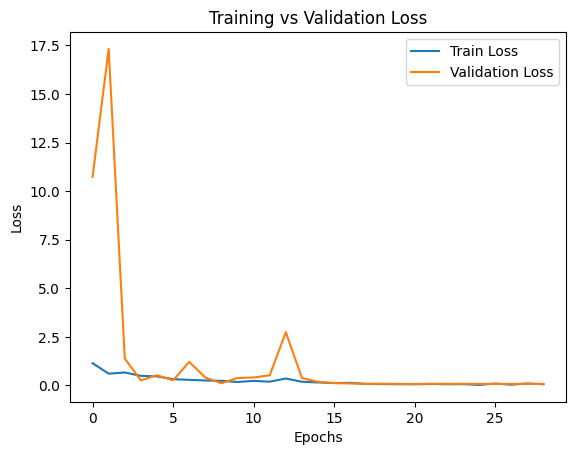

In [ ]:
# Finally, train the model with 50 epochs on maximum, with early stopping if validation loss not improving within 8 consecutive epochs
train(model, train_loader, val_loader, epochs=50, patience=8)

The final validation EMR is around 0.97. This validation process surely can be improved to ensure robust validation results, such as implementing K-Fold. Unfortunately, we are  not be able to implement K-Fold due to Colab GPU limitation (we choose not to purchase for more compute resources)

Despite the limitation of this validation ensurance, the prediction of this model achieves 0.97 EMR on the Public Leaderboard, which complies with this Local Validation result.

In [ ]:
''' UNCOMMENT THIS TO SAVE MODEL '''
# torch.save(model.state_dict(), '/content/drive/MyDrive/hologyv7/clothing_dataset/EfficientNetB7_MTL_Tim_Apalah.pth')


''' UNCOMMENT THIS TO LOAD THE TRAINED EfficientNetB7 MODEL '''
# model = EfficientNetB4_MTL().to(device)
# model.load_state_dict(torch.load('/content/drive/MyDrive/hologyv7/clothing_dataset/EfficientNetB7_MTL_Tim_Apalah.pth'))
# model.eval()

#9.See Exact Match Ratio (EMR) on Validation Set

Next, we evaluate the model's performance on the validation set by identifying and displaying images that were misclassified. The display_falsely_classified_images_and_emr function sets the model to evaluation mode, then iterates through the validation data to make predictions. It compares the predicted labels for jenis and warna with the actual labels, counting correct predictions and storing misclassified images along with their predicted and actual labels.

The Exact Match Ratio (EMR) is calculated based on the number of correct predictions, providing a quantitative measure of the model's accuracy. Finally, it visualizes the misclassified images in a grid format, allowing for a visual assessment of the model's performance.

Exact Match Ratio (EMR): 0.9744
Total false predictions: 5 out of 195 images




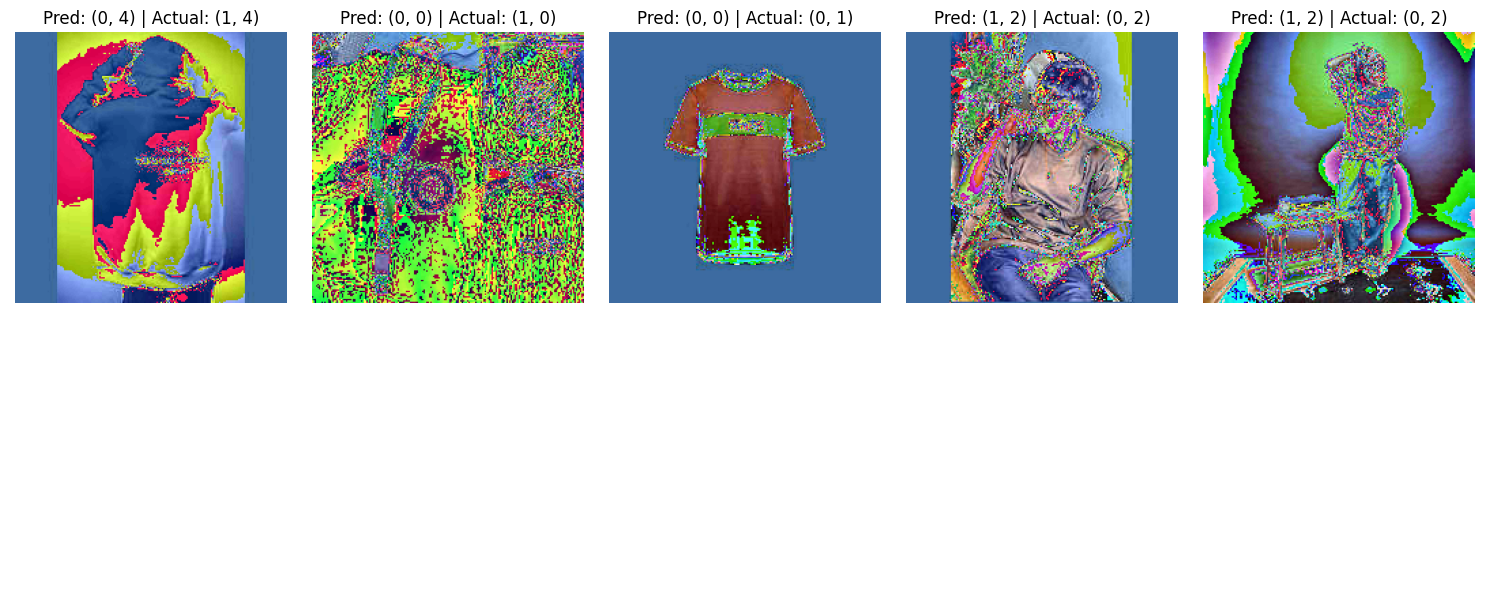

In [ ]:
# Section 9: See EMR on Validation Set and Displaying the missclassified images

def display_falsely_classified_images_and_emr(model, loader):
    """Display all images from the test set that are falsely classified and show the Exact Match Ratio."""
    model.eval()  # Set model to evaluation mode

    false_predictions = []  # Store (image, predicted, actual) for false predictions
    correct_count = 0       # Count the number of correct predictions
    total_count = 0         # Total number of predictions

    with torch.no_grad():
        for images, jenis, warna in loader:
            images = images.to(device)
            jenis = jenis.to(device)
            warna = warna.to(device)

            jenis_out, warna_out = model(images)

            jenis_pred = torch.argmax(jenis_out, dim=1)  # Get predicted 'jenis'
            warna_pred = torch.argmax(warna_out, dim=1)  # Get predicted 'warna'

            # Check predictions and count correct/false predictions
            for i in range(len(images)):
                total_count += 1  # Increment total predictions
                if (jenis_pred[i] == jenis[i]) and (warna_pred[i] == warna[i]):
                    correct_count += 1  # Increment correct predictions
                else:
                    false_predictions.append(
                        (
                            images[i].cpu(),  # Store the image tensor
                            (jenis_pred[i].item(), warna_pred[i].item()),  # Predicted labels
                            (jenis[i].item(), warna[i].item())  # Actual labels
                        )
                    )

    # Calculate Exact Match Ratio (EMR)
    emr = (correct_count / total_count)
    print(f"Exact Match Ratio (EMR): {emr:.4f}")
    print(f"Total false predictions: {len(false_predictions)} out of {total_count} images")
    print('\n')

    # Plot the falsely classified images
    num_images = len(false_predictions)
    cols = 5  # Number of images per row
    rows = (num_images // cols) + 1  # Calculate rows needed

    fig, axes = plt.subplots(rows, cols, figsize=(15, 3 * rows))
    axes = axes.flatten()  # Flatten in case of multiple rows

    for i, (img, pred, actual) in enumerate(false_predictions):
        img = img.permute(1, 2, 0).numpy()  # Convert tensor to numpy (C, H, W) -> (H, W, C)
        img = (img * 255).astype('uint8')  # Rescale to 0-255 for display

        axes[i].imshow(img)  # Display the image
        axes[i].set_title(f"Pred: {pred} | Actual: {actual}")  # Show predictions vs actual
        axes[i].axis('off')  # Turn off axis

    # Hide any extra subplots if the number of false predictions is less than grid size
    for j in range(i + 1, len(axes)):
        axes[j].axis('off')

    plt.tight_layout()  # Adjust layout for better spacing
    plt.show()

# Create the validation dataset with original images enabled
val_dataset = ClothingDataset(
    val_df,
    img_dir='/content/drive/MyDrive/hologyv7/clothing_dataset/train/train',
    transform=test_transform,
)

# DataLoader for the validation set
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)

# Display falsely classified images and EMR
display_falsely_classified_images_and_emr(model, val_loader)


The above results can be understood as (x,y) where x is 'jenis' and y is 'warna'. On validation set, the model missclassified 5 out of 195 images. 2 of those 5 are the missclassification of 'warna' and 3 of those are of 'jenis'

#10.Make Predictions on Test Set and Create Submission File

We make predictions on a test dataset and prepare a submission file. The generate_predictions function is defined to run the model in evaluation mode, where it iterates through the test images, retrieves the outputs for both the jenis and warna classifications, and stores the predicted labels as pairs. After generating predictions, a submission DataFrame is created, which combines the test IDs with the corresponding predictions. Finally, the DataFrame is saved as a CSV file, ready for submission.

In [ ]:
# Section 10: Make Predictions on Test Set and Create Submission File

# Create a test dataset and DataLoader
test_ids = range(778, 1112)  # Define the range of test IDs
test_df = pd.DataFrame({'id': test_ids})  # Create DataFrame for test IDs

# Set is_test=True to make the loader returning only images
test_dataset = ClothingDataset(df=test_df, img_dir='/content/drive/MyDrive/hologyv7/clothing_dataset/test/test', transform=test_transform, is_test=True)
submission_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)  # DataLoader for test dataset

# Modify prediction function to handle single model with two outputs
def generate_predictions(model, submission_loader):
    model.eval()  # Set model to evaluation mode

    predictions = []  # List to store predictions
    with torch.no_grad():
        for images in submission_loader:  # Only images are returned in submission_loader
            images = images.to(device)  # Move images to device

            # Forward pass through the model
            jenis_outputs, warna_outputs = model(images)

            # Get predicted labels for both outputs
            jenis_predicted = torch.argmax(jenis_outputs, dim=1).cpu().numpy()  # Predicted 'jenis'
            warna_predicted = torch.argmax(warna_outputs, dim=1).cpu().numpy()  # Predicted 'warna'

            # Store predictions as pairs
            for j, w in zip(jenis_predicted, warna_predicted):
                predictions.append([j, w])  # Append the predicted labels

    return predictions

# Generate predictions using the unified model
preds = generate_predictions(model, submission_loader)

# Create submission DataFrame
submission_df = pd.DataFrame(preds, columns=['jenis', 'warna'])  # Create DataFrame for predictions
submission_df.insert(0, 'id', test_ids)  # Insert test IDs as the first column

# Save the predictions to a CSV file
submission_df.to_csv('/content/drive/MyDrive/hologyv7/clothing_dataset/submission.csv', index=False)  # Save DataFrame to CSV
submission_df.info()  # Display information about the submission DataFrame

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 334 entries, 0 to 333
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   id      334 non-null    int64
 1   jenis   334 non-null    int64
 2   warna   334 non-null    int64
dtypes: int64(3)
memory usage: 8.0 KB


#11.Conclusion

In this attempt of solving the competition problem, We, Tim Apalah, developed a multi-task learning model for clothing classification, achieving an Exact Match Ratio (EMR) of 0.97 On both Local Validation and Public Leaderboard. Utilizing the EfficientNetB7 architecture, the model was able to effectively classify clothing items based on two attributes: type (jenis) and color (warna). Throughout the process, various architectures were explored, but EfficientNetB7 stood out for its superior performance in terms of EMR. The implementation included robust data preparation, training procedures with early stopping to prevent overfitting, and a comprehensive evaluation of the model’s predictions.

#12.References

[1] Geron, A. (2023). Machine learning with scikit-learn, Keras & TensorFlow. O’Reilly.

[2] [EfficientNet: Rethinking Model Scaling for Convolutional Neural Networks (ICML 2019)](https://arxiv.org/abs/1905.11946)